In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os

In [8]:
#read data and fix
field_data = pd.read_csv('Latvian_Image_data/gt.csv', sep=';')
field_data['VOLUME'] = [float(x.replace(',', '.')) for x in field_data['VOLUME']]
field_data['BIOMAS'] = [float(x.replace(',', '.')) for x in field_data['BIOMAS']]

lidr_data = pd.read_csv('Latvian_Image_data/lidr-metrics.csv')

<Axes: xlabel='zq95', ylabel='H_AVERAGE'>

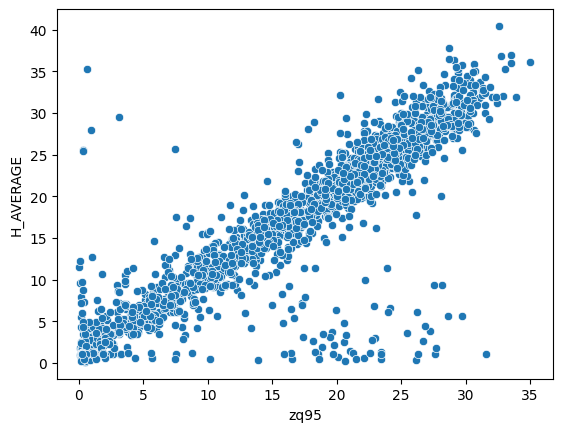

In [9]:
#merge field data and lidr metrics
merged_data = pd.merge(left = field_data, right = lidr_data, left_on = 'IDENTIF', right_on = 'Plot', how='inner')
sns.scatterplot(x = 'zq95', y = 'H_AVERAGE', data = merged_data)

In [10]:
#read raster data based on nfi plot names, and store corresponding nfi target data (to have same dataset for all methods)
raster_data_path = r'..\Latvian_Image_data\tif_surrounding_processed'
raster_images_paths = []
for index, row in merged_data.iterrows():
    path = os.path.join(raster_data_path, str(row['IDENTIF']) + '.tif')
    merged_data.loc[index, 'raster_image_path'] = path
merged_data.dropna(subset=['raster_image_path'], inplace=True)
merged_data

,X,Y,ID,Dubulti_2,IDENTIF,LAND_USE,SITE_TYPE,PLOT_AREA,DOMINANT_SPECIE,DOMINANT_SPECIE_AGE,...,p4th,p5th,pground,n,area,l_1,l_2,t_3,t_4,raster_image_path
0,645149,180625,1902527,1,2434251134,62,5,500,8,31,...,0.986592,0.075892,18.644068,3953,629.7588,3.899034,2.503344,0.378459,0.062435,..\Latvian_Image_data\tif_surrounding_processe...
1,647125,184850,1873982,1,2434255331,10,5,500,1,121,...,3.892165,0.539174,11.036226,5935,632.5221,11.171601,3.184951,-0.201397,0.092307,..\Latvian_Image_data\tif_surrounding_processe...
2,643125,192850,1873985,1,2434443431,10,5,500,3,48,...,3.255128,0.479057,14.691070,8141,633.5285,13.048838,4.472386,-0.143999,0.023615,..\Latvian_Image_data\tif_surrounding_processe...
3,643350,192875,1873988,1,2434443432,10,15,500,4,32,...,0.941915,0.078493,15.436944,3822,632.0192,7.531918,3.755715,0.097097,-0.103645,..\Latvian_Image_data\tif_surrounding_processe...
4,643375,192650,1873991,1,2434443433,10,5,500,3,52,...,2.004264,0.383795,24.200426,4690,632.7734,8.547887,5.191323,0.268553,-0.072193,..\Latvian_Image_data\tif_surrounding_processe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,601350,412874,1898493,1,5411313232,10,10,500,3,37,...,1.656856,0.130804,13.211249,4587,633.2766,7.526290,2.644056,-0.097768,0.022385,..\Latvian_Image_data\tif_surrounding_processe...
1968,601376,412648,1898496,1,5411313233,10,5,500,3,26,...,0.943194,0.000000,13.097535,4665,633.0247,5.694124,2.579557,0.053611,-0.055528,..\Latvian_Image_data\tif_surrounding_processe...
1969,601151,412620,1898499,1,5411313234,10,10,500,4,36,...,1.395768,0.090050,12.809545,4442,632.5216,8.683361,3.016247,-0.100126,0.029883,..\Latvian_Image_data\tif_surrounding_processe...
1970,621124,412850,1898502,2,5411353231,10,8,500,3,42,...,3.240202,0.485060,20.566550,5154,632.7740,4.585673,2.396921,0.148424,-0.061120,..\Latvian_Image_data\tif_surrounding_processe...


coef: 0.9379302517430218, intercept: 1.7066601828656864


Text(0.5, 1.0, 'percentage of data removed: 2.9918864097363085 %')

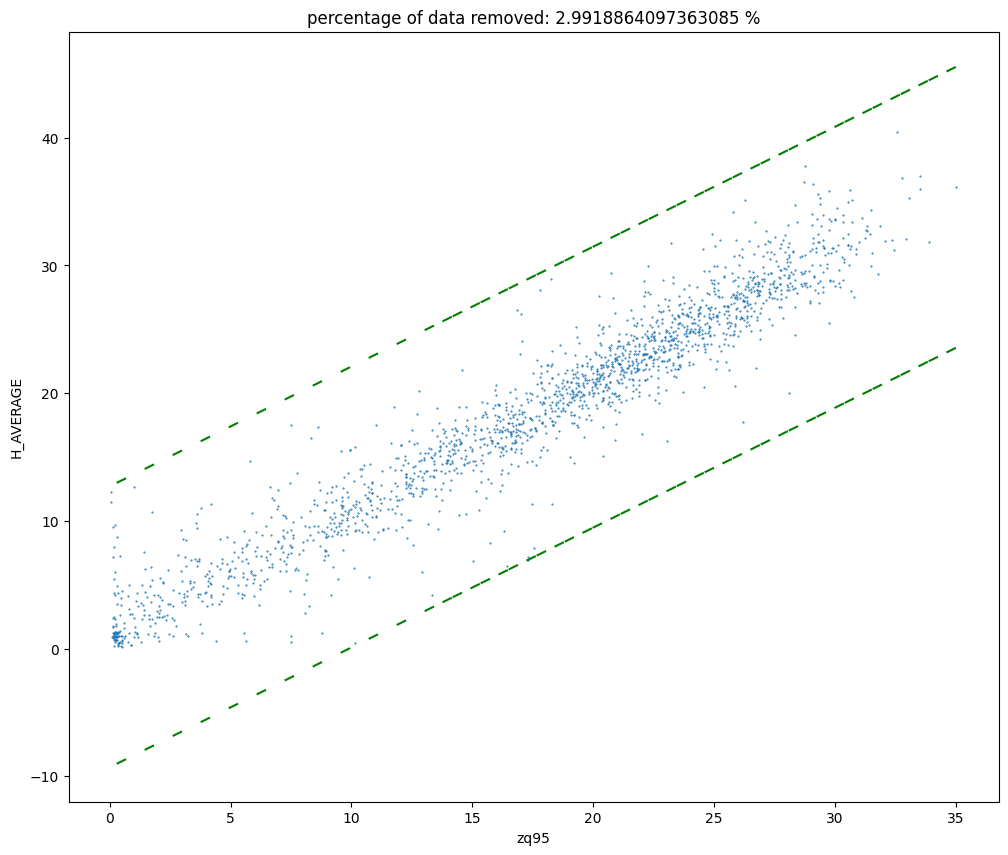

In [11]:
#build a linear regression model on h_p95 vs ground truth height
#use linear regression to remove anomalies
#adjust the threshold to match harvested stem volume (in Latvia ~ 3%)
margin_pos = 11 #adjust this if needed
margin_neg = -11
merged_data_cleaned = merged_data
z95s = np.array(merged_data['zq95']).reshape(-1, 1)
heights = merged_data['H_AVERAGE']
reg = LinearRegression().fit(z95s, heights)
a = reg.coef_[0]
b = reg.intercept_
print(f'coef: {a}, intercept: {b}')

indices_to_keep = []
for index, row in merged_data_cleaned.iterrows():
    height = row['H_AVERAGE']
    zq95 = row['zq95']
    pred_height = a* zq95 + b
    if margin_neg < height - pred_height < margin_pos:
        indices_to_keep.append(index)

merged_data_cleaned = merged_data_cleaned.loc[indices_to_keep]          
plt.figure(figsize = (12,10))
plt.plot(merged_data_cleaned['zq95'], merged_data_cleaned['H_AVERAGE'], '.', markersize = 1)
plt.plot(merged_data_cleaned['zq95'], a* merged_data_cleaned['zq95'] + b + margin_pos, '--', color = 'g', dashes = (5,10))
plt.plot(merged_data_cleaned['zq95'], a* merged_data_cleaned['zq95'] + b + margin_neg, '--', color = 'g', dashes = (5,10))
plt.xlabel('zq95')
plt.ylabel('H_AVERAGE')
#check ow much data is removed
plt.title(f'percentage of data removed: {((len(merged_data) - len(merged_data_cleaned)) / len(merged_data)) * 100} %')

In [12]:
#save to new csv file
merged_data_cleaned.to_csv('Latvian_Image_data/merged_data_cleaned.csv')